In [1]:
import dctkit as dt
from dctkit import config
from dctkit.mesh import util, simplex
from dctkit.dec import cochain as C
from dctkit.dec import vector as V
from alpine.gp import gpsymbreg as gps
from deap import gp
import jax.numpy as jnp
from jax import Array
import numpy as np
import scipy
from scipy.sparse.linalg import cg, spilu, LinearOperator
from typing import Callable, Tuple
import numpy.typing as npt
from time import perf_counter
import ray
import yaml

In [2]:
config()

In [3]:
def assemble_Laplace_operator(S: simplex.SimplicialComplex, k: C.CochainD1V = None) -> Array:
    n = S.num_nodes
    num_edges = S.S[1].shape[0]
    coeffs = jnp.eye(n)
    # build a vector-valued 0-cochain such that each 0-simplex has a one-hot vector
    I = C.CochainP0V(S, coeffs)
    #!!
    if k is None:
        k = C.CochainD1V(S, jnp.ones((num_edges, 1), dtype=dt.float_dtype))
       
    dI = C.coboundary(I)
    # extract the matrix of the conformal Laplacian operator (d * k d)
    A = C.coboundary(C.cochain_mul(k, C.star(dI))).coeffs
    #A = C.coboundary(C.star(dI)).coeffs
    return A

def get_source_vector(S: simplex.SimplicialComplex) -> Array:
    # source term of the equation Au + f = 0, with u = x² + y²
    n = S.num_nodes
    f_vec = -4.*jnp.ones(n, dtype=dt.float_dtype)
    f = C.Cochain(0, True, S, f_vec)
    b = -C.star(f).coeffs
    return b

In [4]:
#@ray.remote(num_cpus=2)
def eval_precond_performance(individual: Callable, x01: C.CochainD1V, x11: C.CochainD1V, bnd_nodes: list,
                             S: simplex.SimplicialComplex, u_true: npt.NDArray, idx_last_bnd_node: int,
                             A: npt.NDArray, b: npt.NDArray) -> Tuple[int, float]:
    
    config()
    
    iter = 0
    # callback function as a counter of iterations
    def callback(kk):
        nonlocal iter
        iter += 1

    # build the preconditioner and start timing (NOTE: should average)
    tic = perf_counter()
    if individual is not None:
        #print("Using preconditioner...")
        k = individual(x01, x11)
        P = assemble_Laplace_operator(S, k)
        P = jnp.delete(P, np.array(bnd_nodes), axis=0)
        P = jnp.delete(P, np.array(bnd_nodes), axis=1)
        P = P.__array__()
    else:
        P = None

    # solve the system
    x, _ = cg(A, b, callback=callback, M=P, tol=0., atol=1e-7, maxiter=1000)
    toc = perf_counter()
    
    error = np.linalg.norm(x-u_true[idx_last_bnd_node+1:])**2
    
    return iter, toc-tic

#def eval_MSE(individual: Callable, indlen: int, X: npt.NDArray, y: npt.NDArray,
#             bvalues: dict, S: SimplicialComplex, bnodes: npt.NDArray,
#             gamma: float, u_0: npt.NDArray, penalty: dict) -> float:
#
#    MSE, _ = eval_MSE_sol(individual, indlen, X, y, bvalues, S, bnodes, gamma, u_0)
#
#    return MSE


@ray.remote(num_cpus=2)
def fitness(individual: Callable, x01: C.CochainD1V, x11: C.CochainD1V, bnd_nodes: list,
            S: simplex.SimplicialComplex, u_true: npt.NDArray, idx_last_bnd_node: int,
            A: npt.NDArray, b: npt.NDArray) -> Tuple[float, ]:

    iter, _ = eval_precond_performance(individual, x01, x11, bnd_nodes, S, u_true, idx_last_bnd_node, A, b)
    
    fitness = iter

    return fitness,

In [5]:
def stgp_Laplace_preconditioner():
    with open("precond.yaml") as config_file:
        config_file_data = yaml.safe_load(config_file)
    
    # generate mesh and simplicial complex
    mesh, _ = util.generate_square_mesh(0.05)
    S = util.build_complex_from_mesh(mesh, is_well_centered=True)
    S.get_hodge_star()
    S.get_flat_PDP_weights()
    n = S.num_nodes
    bnd_nodes = util.get_nodes_for_physical_group(mesh, 1, "boundary")
    idx_last_bnd_node = int(bnd_nodes[-1])
    node_coord = S.node_coords
    print("Number of nodes = ", n)

    # build 0-cochains of the node coordinates
    x0 = C.CochainP0(S, jnp.array(S.node_coords[:,0].ravel(), dtype=dt.float_dtype))
    x1 = C.CochainP0(S, jnp.array(S.node_coords[:,1].ravel(), dtype=dt.float_dtype))
    # convert them into dual vector-valued 1-cochains (maybe reshape could be done inside the assemble function and define these as scalar-valued dual 1-coch)
    x01 = C.star(V.flat_PDP(x0))
    x11 = C.star(V.flat_PDP(x1))
    x01.coeffs = x01.coeffs.reshape(-1,1)
    x11.coeffs = x11.coeffs.reshape(-1,1)
    
    # define true solution for the discrete problem Au + f = 0
    u_true = np.array(node_coord[:, 0]**2 + node_coord[:, 1]**2, dtype=dt.float_dtype)
    ub = u_true[bnd_nodes]

    A = assemble_Laplace_operator(S)
    b = get_source_vector(S)
    Ab = A[idx_last_bnd_node+1:,:idx_last_bnd_node+1]
    # sanity check
    #x = scipy.linalg.solve(A,b)
    #print(x)
    #print(u_true[idx_last_bnd_node+1:])
    
    # apply Dirichlet BC and reduce the system to the unknown values of u
    A = jnp.delete(A, np.array(bnd_nodes), axis=0)
    A = jnp.delete(A, np.array(bnd_nodes), axis=1)
    b = jnp.delete(b, np.array(bnd_nodes))
    b -= Ab @ ub

    # convert jax arrays to numpy (for use with scipy)
    A = A.__array__()
    b = b.__array__()

    pset = gp.PrimitiveSetTyped("MAIN", [C.CochainD1V, C.CochainD1V], C.CochainD1V)
    # ones cochain
    pset.addTerminal(C.Cochain(S.num_nodes, True, S, np.ones(S.num_nodes, dtype=dt.float_dtype)), C.Cochain, name="ones")
    
    # add constants
    pset.addTerminal(0.5, float, name="1/2")
    pset.addTerminal(-1., float, name="-1.")
    pset.addTerminal(2., float, name="2.")
    # rename arguments
    pset.renameArguments(ARG0="x0")
    pset.renameArguments(ARG1="x1")

    ray.shutdown()
    # create symbolic regression problem instance
    GPprb = gps.GPSymbRegProblem(pset=pset, config_file_data=config_file_data)

    GPprb.store_eval_common_params({'S': S, 'x01': x01, 'x11': x11, 'bnd_nodes': bnd_nodes,
                                    'u_true': u_true, 'idx_last_bnd_node': idx_last_bnd_node, 
                                    'A': A, 'b': b})

    params_names = ('b')
    # FIXME: here specifying at least train and test is mandatory, even if we not use test
    # Also, maybe we do not want to use "dataset", but just pass all the arguments via common params
    datasets = {'train': [b], 'test': [b]}
    GPprb.store_eval_dataset_params(params_names, datasets)

    GPprb.register_eval_funcs(fitness=fitness.remote)

    GPprb.register_map([])

    start = perf_counter()
    # opt_string = "SquareF(InnP0(InvMulP0(u, InnP0(u, fk)), delP1(dP0(u))))"
    # opt_string = "SubF(InnP1(cobP0(u), cobP0(u)), MulF(2., InnP0(f, u)))"
    # opt_individ = creator.Individual.from_string(opt_string, pset)
    # seed = [opt_individ]

    GPprb.run(print_log=True)

    print(f"Elapsed time: {round(perf_counter() - start, 2)}")

Number of nodes =  513


2023-11-10 09:01:12,631	INFO worker.py:1621 -- Started a local Ray instance.


> MODEL TRAINING/SELECTION STARTED
Generating initial population...
DONE.
 -= START OF EVOLUTION =- 
Evaluating initial population...


(fitness pid=7078) 2023-11-10 09:01:14.771536: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(fitness pid=7078) No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


DONE.
   	     	            fitness            	             size             
   	     	-------------------------------	------------------------------
gen	evals	min	avg   	max	std    	min	avg 	max	std   
1  	100  	287	326.51	451	58.4163	2  	4.94	14 	2.1393
The best individual of this generation is: AddCD1V(ExpD1V(x0), InvMD1V(x1, 2.))
2  	100  	287	289.58	291	0.8022 	2  	5.23	14 	2.4325
The best individual of this generation is: AddCD1V(ExpD1V(x0), InvMD1V(x1, 2.))
3  	100  	286	289.07	290	0.8515 	2  	5.19	13 	2.1665
The best individual of this generation is: AddCD1V(ExpD1V(x0), InvMD1V(x1, SquareF(ExpF(InvF(-1.)))))
4  	100  	286	288.62	289	0.675  	2  	5.59	13 	2.2851
The best individual of this generation is: AddCD1V(ExpD1V(x0), InvMD1V(x1, SquareF(ExpF(InvF(-1.)))))
5  	100  	286	288.35	289	0.8292 	2  	5.68	13 	2.1903
The best individual of this generation is: AddCD1V(ExpD1V(x0), InvMD1V(x1, SquareF(ExpF(InvF(-1.)))))
6  	100  	281	287.95	289	1.1347 	2  	6.24	17 	2.4622
The best in

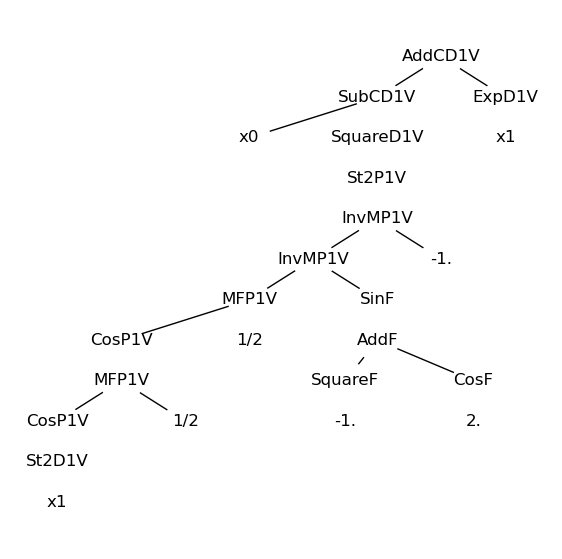

Elapsed time: 101.33


In [6]:
stgp_Laplace_preconditioner()